# Turbine Characteristics Modelling

> Date:

> Author: Elias Aoubala 

In [1]:
from turborocket.transient.start_up import Pump, Turbine, GasGenerator
from turborocket.characteristic.turbo_characteristic import TurboCharacteristics
from turborocket.fluids.fluids import IncompressibleFluid
import numpy as np
import handcalcs.render
import CoolProp.CoolProp as CP

import matplotlib.pyplot as plt

## 1 - Background

This document includes the relevant test cases to confirm that turbine modelling is meeting realistic expectations, as indicated by literature.

## 2 - Litterature

[First Paper](https://ntrs.nasa.gov/api/citations/19720005134/downloads/19720005134.pdf)

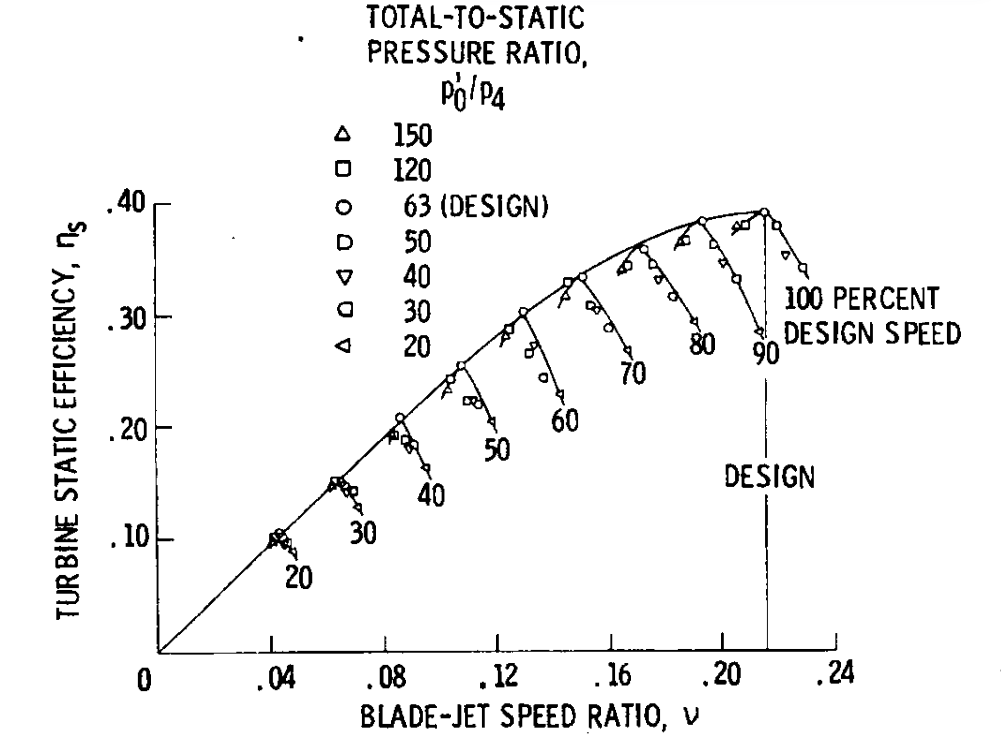

[Second Paper](https://ntrs.nasa.gov/api/citations/20030062761/downloads/20030062761.pdf)

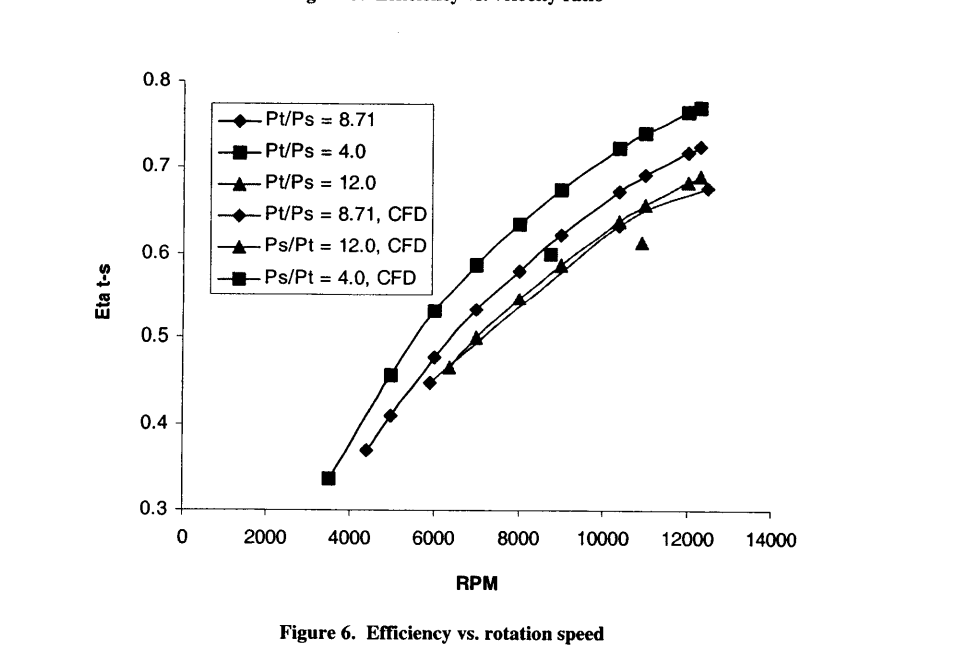



## 3 - Modelling Plots

First thing we need to do is intantiate and size all of our key objects we use in the analysis

In [2]:
%%render param

rho_ox = 786  # kg/m**3
rho_fu = 788 # kg/m**3

<IPython.core.display.Latex object>

### 3.1 - Gas Generator Sizing

The gas generator has the following sizing:

In [3]:
%%render param sci_not

Pcc = 25e5 # Pa
MR_nom = 1
eta_c = 0.85
m_dot_t = 38.655e-3 # kg/s


<IPython.core.display.Latex object>

**Injector Parameters**

Fuel Side:

In [4]:
%%render param sci_not

Pf_inlet = 50e5 # Pa
rho_f_inlet = 786 # kg/s
Cd_f = 0.4

<IPython.core.display.Latex object>

Oxidiser Side:

In [5]:
%%render param sci_not

Po_inlet = 50e5 # Pa
rho_o_inlet = CP.PropsSI("D", "P", Po_inlet, "Q", 0, "NitrousOxide") # kg/s
Cd_o = 0.5

<IPython.core.display.Latex object>

We then define our classes for the gas generator

In [6]:
Nitrous = IncompressibleFluid(rho=rho_o_inlet, P=Po_inlet)
IPA = IncompressibleFluid(rho=rho_f_inlet, P=Pf_inlet)

GG = GasGenerator(
    Ox="N2O", Fu="C3H8O,2propanol", Pcc=Pcc, MR=MR_nom)  # , look_up_file="combustion_date.csv"

GG.comb_object(look_up=True, look_up_file="combustion_date.csv", combustion_file="n2o_ipa.yaml")

In [7]:
GG.get_c_star(Pcc=10e5, MR=1, eta_c=1)

array([1122.72456918])

In [8]:
GG.injector_cond(ox_in=Nitrous, fu_in=IPA, cdo=Cd_o, cdf=Cd_f)

GG.size_system(m_dot=m_dot_t, eta_c=eta_c)

{'P_cc': 2500000.0,
 'MR': np.float64(1.0),
 'T_o': array([928.82770857]),
 'Cp': array([4857.0875648]),
 'gamma': array([1.28212248]),
 'R': array([484.16983562]),
 'ox_stiffness': 1.0,
 'fu_stiffness': 1.0,
 'm_dot_t': array([0.038655]),
 'm_dot_o': array([0.0193275]),
 'm_dot_f': array([0.0193275])}

### 3.2 - Pump Sizing

Pump is also sized normally as follows:

In [9]:
pump = Pump(D = 53.79e-3,
            Q_nom = 1.15/(60*60),
            eta_nom = 0.293,
            N_nom = 24e3 * 2 * np.pi/60)

### 3.3 - Turbine Sizing

The turbine is sized as follows:

In [10]:
turbine = Turbine(a_rat = 4.11,
                  D_m = 0.147, 
                  eta_nom = 0.1,
                  u_co_nom = 0.13)

### 3.4 - Turbopump Characteristic Map Generation

We can now instantiate our turbopump map based on our individual objects we have created

In [11]:
characteristic = TurboCharacteristics(pump = pump,
                                      turbine = turbine,
                                      gas_generator = GG)

We can then create a mesh grid of inlet pressures and mass flow rates to resolve for the system conditions accordingly.

In [50]:
k = 30

p_in_array = np.linspace(20, 50, k) * 1e5 # Pa
m_dot_array = np.linspace(10,50, k) * 1e-3 # kg/s

p_in_array, m_dot_array = np.meshgrid(p_in_array, m_dot_array)

Practice Run

In [51]:
N_array = np.zeros([k, k])
Pw_array = np.zeros([k, k])
eta_array = np.zeros([k, k])

P_exit_array = np.zeros([k, k])
P_gg_inlet_array = np.zeros([k,k])

m_dot_gg_array = np.zeros([k, k])
T_gg_array = np.zeros([k, k])
MR_array = np.zeros([k, k])
P_gg_array = np.zeros([k, k])

error_array = np.zeros([k, k])


for index, x in np.ndenumerate(p_in_array):
    p = p_in_array[index]
    m_dot = m_dot_array[index]

    IPA.set_pressure(P=p)

    result = characteristic.solve_condition(
        fu_inlet=IPA, ox_inlet=Nitrous, m_dot_t=m_dot
    )

    N_array[index] = result["N"]
    Pw_array[index] = result["Power"]

    P_exit_array[index] = result["pump_exit"].get_pressure()
    P_gg_inlet_array[index] = result["gg_fuel_inlet"].get_pressure()

    m_dot_gg_array[index] = result["m_dot_t"]
    T_gg_array[index] = result["T_o"]
    MR_array[index] = result["m_dot_o"] / result["m_dot_f"]

    P_gg_array[index] = result["P_cc"]

    error_array[index] = result["error"]

    eta_array[index] = result["eta"]

    print(f"Done: {index}")

C:\Users\elias\AppData\Local\Temp\ipykernel_20468\464438415.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  N_array[index] = result["N"]
C:\Users\elias\AppData\Local\Temp\ipykernel_20468\464438415.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Pw_array[index] = result["Power"]
C:\Users\elias\AppData\Local\Temp\ipykernel_20468\464438415.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P_exit_array[index] = result["pump_exit"].get_pressure()
C:\Users\e

Done: (0, 0)
Done: (0, 1)
Done: (0, 2)
Done: (0, 3)
Done: (0, 4)
Done: (0, 5)
Done: (0, 6)
Done: (0, 7)
Done: (0, 8)
Done: (0, 9)
Done: (0, 10)
Done: (0, 11)
Done: (0, 12)
Done: (0, 13)
Done: (0, 14)
Done: (0, 15)
Done: (0, 16)
Done: (0, 17)
Done: (0, 18)
Done: (0, 19)
Done: (0, 20)
Done: (0, 21)
Done: (0, 22)
Done: (0, 23)
Done: (0, 24)
Done: (0, 25)
Done: (0, 26)
Done: (0, 27)
Done: (0, 28)
Done: (0, 29)
Done: (1, 0)
Done: (1, 1)
Done: (1, 2)
Done: (1, 3)
Done: (1, 4)
Done: (1, 5)
Done: (1, 6)
Done: (1, 7)
Done: (1, 8)
Done: (1, 9)
Done: (1, 10)
Done: (1, 11)
Done: (1, 12)
Done: (1, 13)
Done: (1, 14)
Done: (1, 15)
Done: (1, 16)
Done: (1, 17)
Done: (1, 18)
Done: (1, 19)
Done: (1, 20)
Done: (1, 21)
Done: (1, 22)
Done: (1, 23)
Done: (1, 24)
Done: (1, 25)
Done: (1, 26)
Done: (1, 27)
Done: (1, 28)
Done: (1, 29)
Done: (2, 0)
Done: (2, 1)
Done: (2, 2)
Done: (2, 3)
Done: (2, 4)
Done: (2, 5)
Done: (2, 6)
Done: (2, 7)
Done: (2, 8)
Done: (2, 9)
Done: (2, 10)
Done: (2, 11)
Done: (2, 12)
Done: (2

We can at long last create our contour plot!

Text(0.5, 1.0, 'Turbopump Shaft Speed')

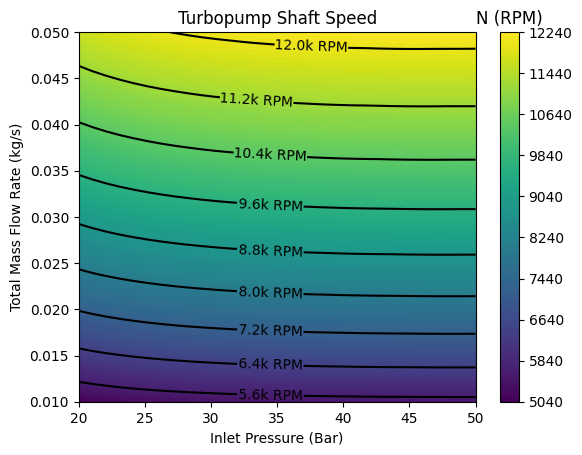

In [52]:
cs = plt.contourf(p_in_array/1e5, m_dot_array, N_array*60/(2*np.pi), levels=100)

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, N_array * 60 / (2 * np.pi), levels=8, colors="k"
)

def formatter(input):
    return f" {input/1e3:.1f}k RPM "

cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title("N (RPM)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Turbopump Shaft Speed")

Text(0.5, 1.0, 'Turbopump Delivery Pressure')

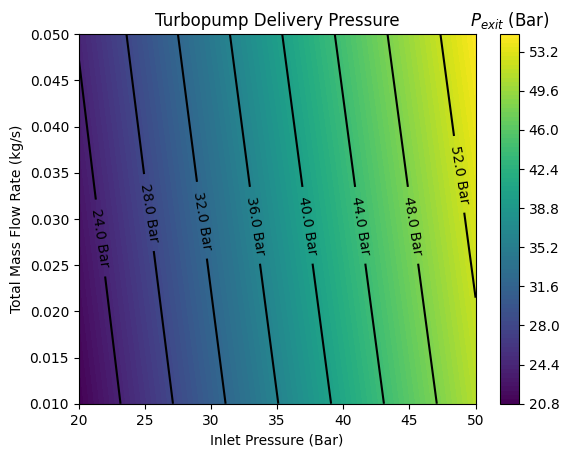

In [53]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, P_exit_array/1e5, levels=100)

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, P_exit_array / 1e5, levels=8, colors="k"
)


def formatter(input):
    return f" {input:.1f} Bar "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$P_{exit}$ (Bar)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Turbopump Delivery Pressure")

Text(0.5, 1.0, 'Gas Generator Combustion Temperature')

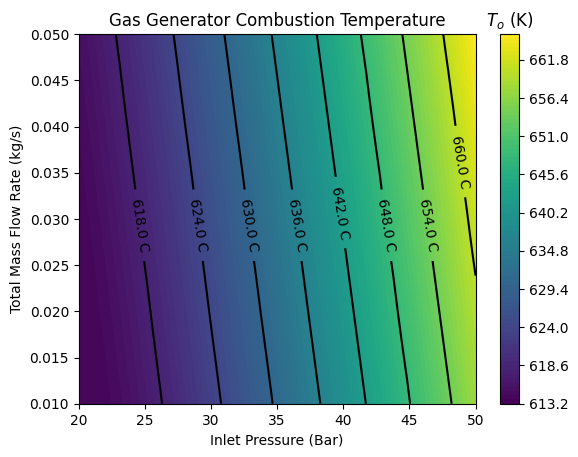

In [54]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, T_gg_array - 273.15, levels=100)

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, T_gg_array - 273.15, levels=8, colors="k"
)


def formatter(input):
    return f" {input:.1f} C "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)


cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$T_o$ (K)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Combustion Temperature")

Text(0.5, 1.0, 'Gas Generator Mixture Ratio')

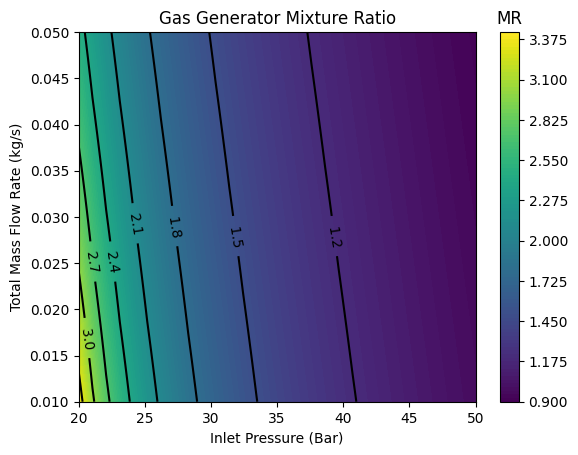

In [55]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, MR_array, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, MR_array, levels=8, colors="k")


def formatter(input):
    return f" {input:.1f} "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"MR")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mixture Ratio")

Text(0.5, 1.0, 'Gas Generator Chamber Pressure')

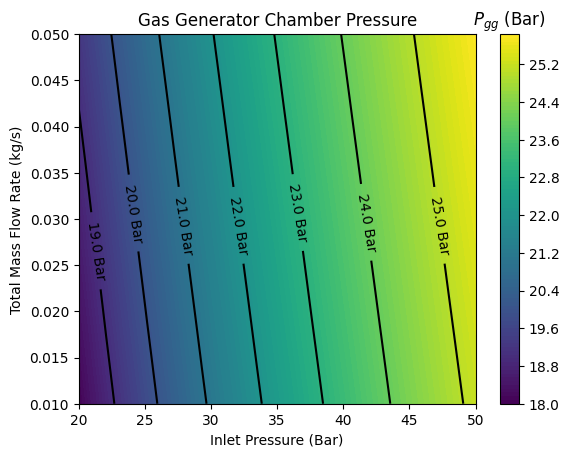

In [56]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, P_gg_array / 1e5, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, P_gg_array / 1e5, levels=8, colors="k")


def formatter(input):
    return f" {input:.1f} Bar "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$P_{gg}$ (Bar)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Chamber Pressure")

Text(0.5, 1.0, 'Gas Generator Mass Flow Rate')

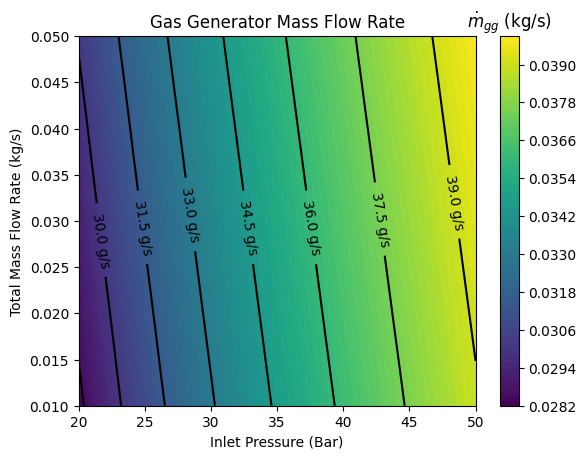

In [57]:

cs = plt.contourf(p_in_array / 1e5, m_dot_array, m_dot_gg_array, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, m_dot_gg_array, levels=8, colors="k")


def formatter(input):
    return f" {input*1e3:.1f} g/s "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\dot{m}_{gg}$ (kg/s)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mass Flow Rate")

Text(0.5, 1.0, 'Gas Generator Mass Flow Rate')

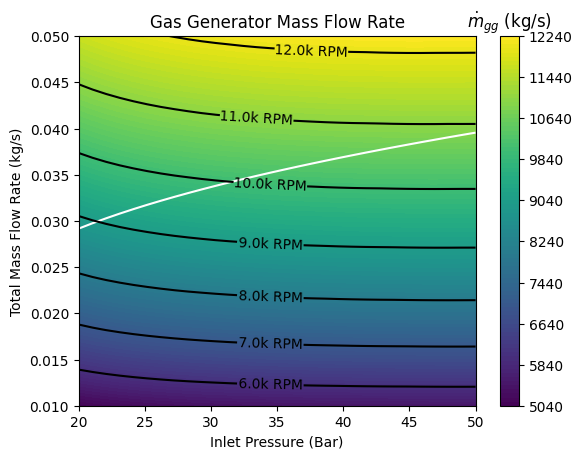

In [66]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, N_array * 60 / (2 * np.pi), levels=100)

cs3 = plt.contour(p_in_array / 1e5, m_dot_array, m_dot_array - m_dot_gg_array, levels=[0], colors="w")

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, N_array * 60 / (2 * np.pi), levels=7, colors="k"
)

def formatter(input):
    return f" {input/1e3:.1f}k RPM "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\dot{m}_{gg}$ (kg/s)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mass Flow Rate")

Text(0.5, 1.0, 'Overall Cycle Efficiency')

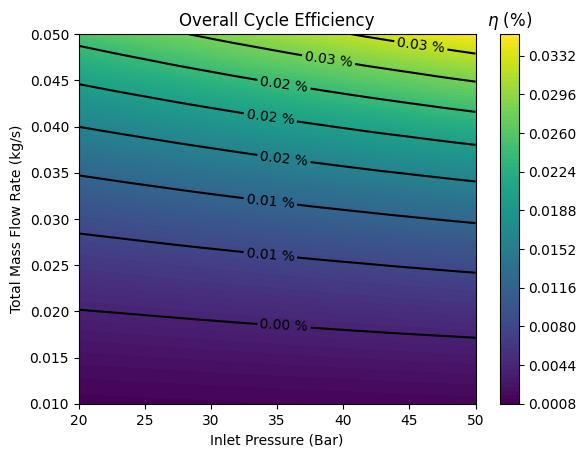

In [60]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, eta_array * 1e2, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, eta_array * 1e2, levels=8, colors="k")


def formatter(input):
    return f" {input:.2f} % "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\eta$ (%)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Overall Cycle Efficiency")

Text(0.5, 1.0, 'Cycle Power')

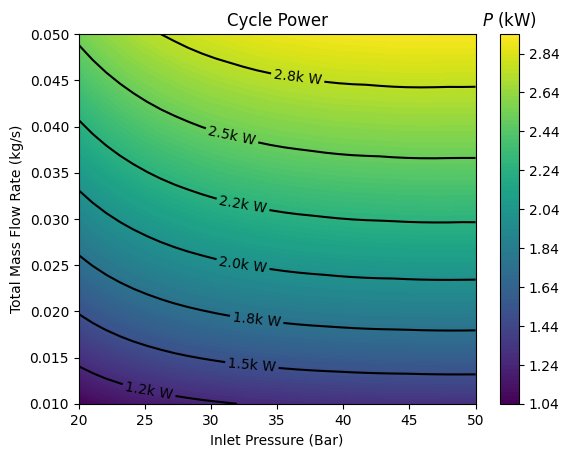

In [65]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, Pw_array/1e3, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, Pw_array/1e3, levels=8, colors="k")


def formatter(input):
    return f" {input:.1f}k W "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$P$ (kW)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Cycle Power")

Text(0.5, 1.0, 'Gas Generator Mass Flow Rate')

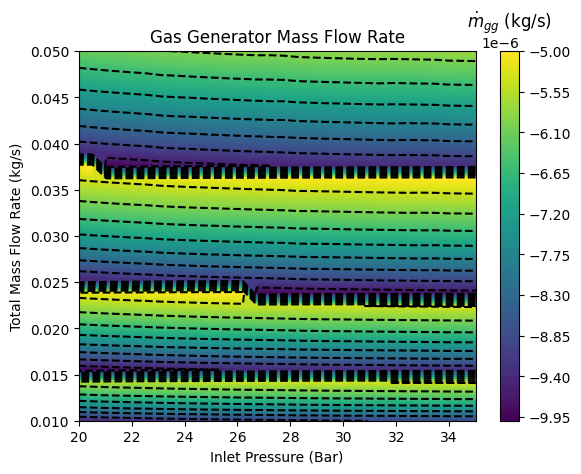

In [40]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, error_array, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, error_array, levels=8, colors="k")


cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\dot{m}_{gg}$ (kg/s)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mass Flow Rate")

We can now make inverted plots describing how the system would fair under different engine propellant draws.

Text(0.5, 1.0, 'Turbopump Shaft Speed')

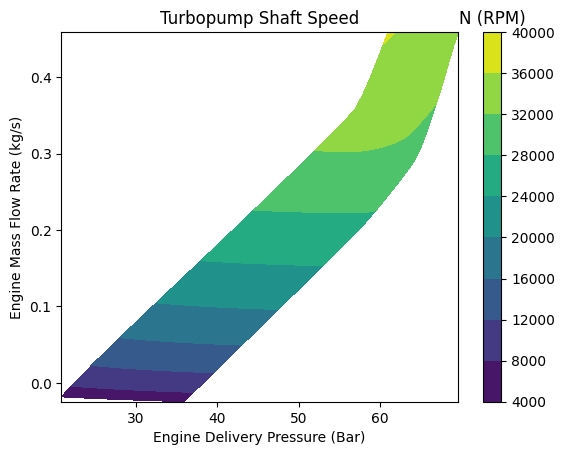

In [22]:
cs = plt.contourf(P_exit_array / 1e5, m_dot_array - m_dot_gg_array, N_array * 60 / (2 * np.pi))

cbar = plt.colorbar(cs)
cbar.ax.set_title("N (RPM)")

plt.xlabel("Engine Delivery Pressure (Bar)")
plt.ylabel("Engine Mass Flow Rate (kg/s)")
plt.title("Turbopump Shaft Speed")

We can go on to overlay our limits in terms of MR and combustion temperature

C:\Users\elias\AppData\Local\Temp\ipykernel_20468\3735672042.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  ax1 = plt.contour(
C:\Users\elias\AppData\Local\Temp\ipykernel_20468\3735672042.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  ax2 = plt.contour(
C:\Users\elias\AppData\Local\Temp\ipykernel_20468\3735672042.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  ax3 = plt.contour(
C:\Users\elias\AppData\Local\Temp\ipykernel_20468\3735672042.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Turbopump Shaft Speed')

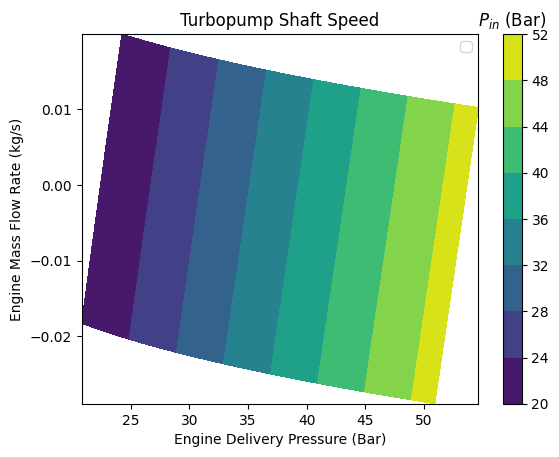

In [67]:
ax0 = plt.contourf(
    P_exit_array / 1e5,
    m_dot_array - m_dot_gg_array,
    p_in_array/1e5
)

ax1 = plt.contour(
    P_exit_array / 1e5, m_dot_array - m_dot_gg_array, N_array * 60 / (2 * np.pi), levels=[21e3, 27e4], label="Rotor Dynamic Modes"
)

ax1.clabel(levels=ax1.levels, inline="True", fmt=f" %d RPM ")

ax2 = plt.contour(
    P_exit_array / 1e5, m_dot_array - m_dot_gg_array, MR_array, levels=[0.8], label="MR Flame Holding Limit"
)

ax2.clabel(levels=ax2.levels, inline="True", fmt=f" %.2f MR ")

ax3 = plt.contour(
    P_exit_array / 1e5, m_dot_array - m_dot_gg_array, T_gg_array - 273.15, levels=[600], label="Thermal Limit"
)

ax3.clabel(levels=ax3.levels, inline="True", fmt=f" %.2f C ")

cbar = plt.colorbar(ax0)
cbar.ax.set_title("$P_{in}$ (Bar)")

plt.legend()

plt.xlabel("Engine Delivery Pressure (Bar)")
plt.ylabel("Engine Mass Flow Rate (kg/s)")
plt.title("Turbopump Shaft Speed")

### 3.5 - Monte Carlo Analysis

In the Turbomachinery design, there are many uknow